In [1]:
from torchvision.datasets import ImageFolder  ## Used for loading the images in folder

from torchvision import transforms ## Used for common image transformation of random area cropping, horizantal flip,
                                   ## tensor conversions and normalization 
    
from sklearn.model_selection import train_test_split  ## Used for splitting the dataset into train and test

from torch.utils.data import DataLoader  ## Used for shuffling and iteration over dataset

from torchvision import models ## For loading pretrained models

from torch.nn import Linear ## For adding classification layer on top of pretrained model

from torch.nn import CrossEntropyLoss ## cost function for training

import torch.optim as optim ## Optimization algorithm



import torch
import time
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


/home/divyapalagati/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/divyapalagati/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


## Data loading and transformations 

Define commom image transformations of Random area cropping and horizantal flipping. And then convert into tensor and normalize for easier calculation

In [2]:
transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Load the image data and split the data into train and test. And then convert the dataset into Data Loader for shuffling and iteration while training and validating

In [3]:
dataset=ImageFolder("./data",transform=transfrom)

train_set,val_set=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

train_loader=DataLoader(train_set, batch_size=32,shuffle=True)

val_loader=DataLoader(val_set, batch_size=32)


In [49]:
len(dataset)

812

## Define train and test functions

Define train function. It contains Passing data to model, Loss function calculation, learning optimization.

In [4]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0],data[1]
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

Define test function for evaluating at each epoch

In [5]:
def test(model,loss_fn,dataloader,epoch):
  model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0],data[1]
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 


## Load the pretrained  model and fine tune for classification task

Load pretrained model (resnet18) from torchvision.models and freeze the parameters. And add a linear layer to it for classification task. And started training.

The extracted features using pretrained model is given to the linear layer for final classification.

In [6]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = Linear(num_ftrs, len(dataset.classes))

loss_fn = CrossEntropyLoss()

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

epochs=30

for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


/home/divyapalagati/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/divyapalagati/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch : 1


100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


Train Loss: 1.133 | Accuracy: 49.153


100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Test Loss: 0.927 | Accuracy: 64.417

Epoch : 2


100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Train Loss: 0.893 | Accuracy: 62.712


100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


Test Loss: 0.810 | Accuracy: 68.098

Epoch : 3


100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Train Loss: 0.747 | Accuracy: 69.183


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Test Loss: 0.745 | Accuracy: 74.847

Epoch : 4


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Train Loss: 0.672 | Accuracy: 73.498


100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


Test Loss: 0.713 | Accuracy: 74.233

Epoch : 5


100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


Train Loss: 0.633 | Accuracy: 74.730


100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


Test Loss: 0.656 | Accuracy: 79.755

Epoch : 6


100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


Train Loss: 0.578 | Accuracy: 79.353


100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


Test Loss: 0.623 | Accuracy: 81.595

Epoch : 7


100%|██████████| 21/21 [00:12<00:00,  1.63it/s]


Train Loss: 0.532 | Accuracy: 79.661


100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Test Loss: 0.607 | Accuracy: 81.595

Epoch : 8


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Train Loss: 0.529 | Accuracy: 82.280


100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Test Loss: 0.619 | Accuracy: 79.755

Epoch : 9


100%|██████████| 21/21 [00:13<00:00,  1.52it/s]


Train Loss: 0.507 | Accuracy: 79.507


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Test Loss: 0.579 | Accuracy: 82.822

Epoch : 10


100%|██████████| 21/21 [00:12<00:00,  1.62it/s]


Train Loss: 0.438 | Accuracy: 86.133


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Test Loss: 0.595 | Accuracy: 81.595

Epoch : 11


100%|██████████| 21/21 [00:13<00:00,  1.60it/s]


Train Loss: 0.431 | Accuracy: 84.284


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Test Loss: 0.555 | Accuracy: 84.049

Epoch : 12


100%|██████████| 21/21 [00:13<00:00,  1.57it/s]


Train Loss: 0.424 | Accuracy: 85.978


100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Test Loss: 0.613 | Accuracy: 80.368

Epoch : 13


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


Train Loss: 0.456 | Accuracy: 84.592


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Test Loss: 0.577 | Accuracy: 82.822

Epoch : 14


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Train Loss: 0.422 | Accuracy: 85.516


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Test Loss: 0.531 | Accuracy: 84.049

Epoch : 15


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


Train Loss: 0.454 | Accuracy: 83.513


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Test Loss: 0.517 | Accuracy: 82.822

Epoch : 16


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


Train Loss: 0.423 | Accuracy: 84.746


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Test Loss: 0.505 | Accuracy: 79.755

Epoch : 17


100%|██████████| 21/21 [00:13<00:00,  1.60it/s]


Train Loss: 0.447 | Accuracy: 83.359


100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


Test Loss: 0.492 | Accuracy: 77.914

Epoch : 18


100%|██████████| 21/21 [00:13<00:00,  1.53it/s]


Train Loss: 0.365 | Accuracy: 87.057


100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Test Loss: 0.543 | Accuracy: 84.049

Epoch : 19


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Train Loss: 0.385 | Accuracy: 86.903


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Test Loss: 0.568 | Accuracy: 84.049

Epoch : 20


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


Train Loss: 0.380 | Accuracy: 87.211


100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Test Loss: 0.492 | Accuracy: 82.209

Epoch : 21


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


Train Loss: 0.368 | Accuracy: 86.595


100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Test Loss: 0.479 | Accuracy: 80.982

Epoch : 22


100%|██████████| 21/21 [00:12<00:00,  1.70it/s]


Train Loss: 0.336 | Accuracy: 88.598


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Test Loss: 0.510 | Accuracy: 84.049

Epoch : 23


100%|██████████| 21/21 [00:13<00:00,  1.53it/s]


Train Loss: 0.338 | Accuracy: 88.598


100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


Test Loss: 0.487 | Accuracy: 82.209

Epoch : 24


100%|██████████| 21/21 [00:13<00:00,  1.61it/s]


Train Loss: 0.358 | Accuracy: 88.906


100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


Test Loss: 0.517 | Accuracy: 83.436

Epoch : 25


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


Train Loss: 0.354 | Accuracy: 90.139


100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Test Loss: 0.474 | Accuracy: 80.982

Epoch : 26


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Train Loss: 0.338 | Accuracy: 88.290


100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


Test Loss: 0.473 | Accuracy: 81.595

Epoch : 27


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


Train Loss: 0.354 | Accuracy: 88.598


100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Test Loss: 0.510 | Accuracy: 84.663

Epoch : 28


100%|██████████| 21/21 [00:13<00:00,  1.59it/s]


Train Loss: 0.329 | Accuracy: 90.139


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Test Loss: 0.587 | Accuracy: 81.595

Epoch : 29


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


Train Loss: 0.350 | Accuracy: 86.903


100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


Test Loss: 0.589 | Accuracy: 82.822

Epoch : 30


100%|██████████| 21/21 [00:18<00:00,  1.15it/s]


Train Loss: 0.325 | Accuracy: 88.136


100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

Test Loss: 0.501 | Accuracy: 82.209


## Test the model with images

Define function to show the images with prediction and lable

In [11]:
def showimages(imgs,actual_lbls,pred_lbls=None):
  
  fig = plt.figure(figsize=(30,12))

  for i,img in enumerate(imgs):
    
    fig.add_subplot(4,8, i+1)
    y=actual_lbls[i]
    
    if pred_lbls!=None:
      y_pre=pred_lbls[i]
      title="prediction: {0}\nlabel:{1}".format(dataset.classes[y],dataset.classes[y_pre])
    else: 
      title="Label: {0}".format(dataset.classes[y])

    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)

Prepare test data

In [46]:
## Load test data

test_data = ImageFolder("./test_data",transfrom)
test_loader=DataLoader(test_data, batch_size=25,)

Make predictions on test data

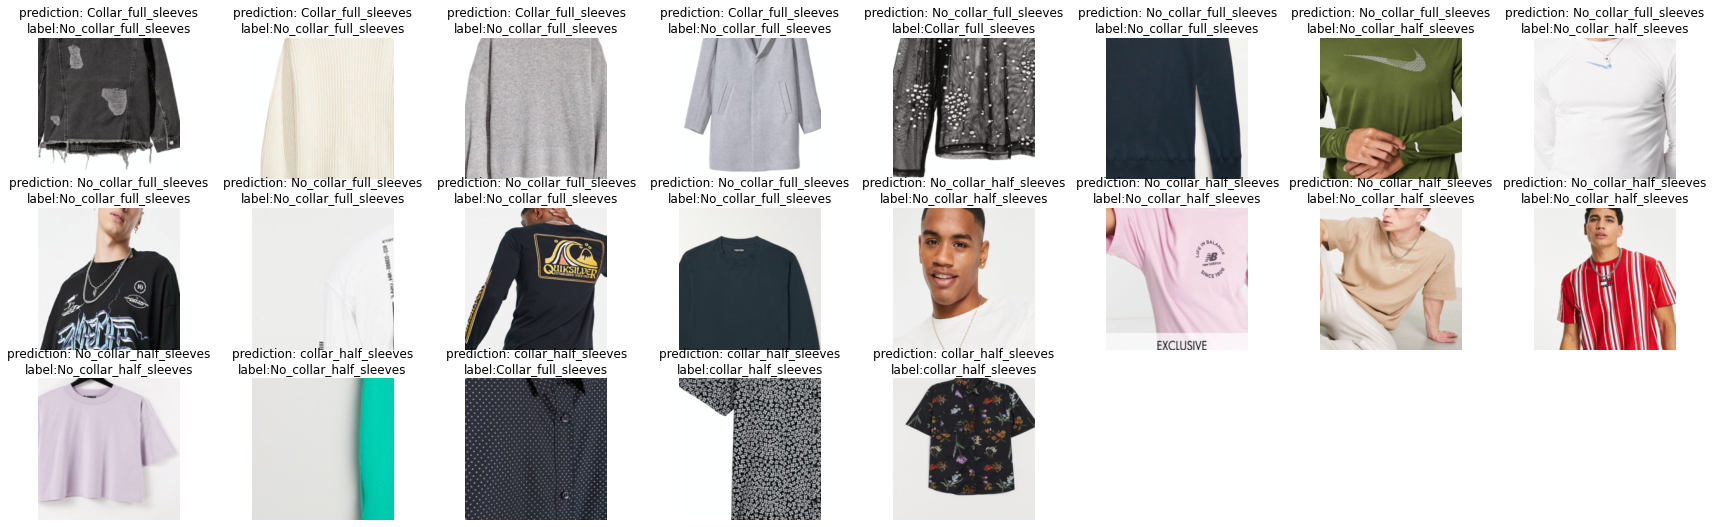

In [47]:
def predict_images(model,images,actual_label):
  model.eval()
  with torch.no_grad():
    inputs = images
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    showimages(images,actual_label,preds.cpu())

images, classes = next(iter(test_loader))

predict_images(model,images,classes)

### Color  detection

In [32]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import extcolors

Read color codes

In [34]:
## Read csv
index=["color","color_name","hex","R","G","B"]
csv = pd.read_csv("colors.csv",names=index, header=None)

In [35]:
csv.head()

color             color_name      hex    R    G    B
0    air_force_blue_raf   Air Force Blue (Raf)  #5d8aa8   93  138  168
1   air_force_blue_usaf  Air Force Blue (Usaf)  #00308f    0   48  143
2  air_superiority_blue   Air Superiority Blue  #72a0c1  114  160  193
3       alabama_crimson        Alabama Crimson  #a32638  163   38   56
4            alice_blue             Alice Blue  #f0f8ff  240  248  255

### Define function to get color from RGB values of pixel

Use extcolors library for finding the distribution of colors. From that seletc the pixel having maximum count and display it as the color of the image.

In [36]:
def getColorName(R,G,B):
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G- int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname


In [40]:
colors_x = extcolors.extract_from_path("./Color_data/1631.jpg", tolerance = 50, limit = 12)
r_g_b = colors_x[0][1][0]

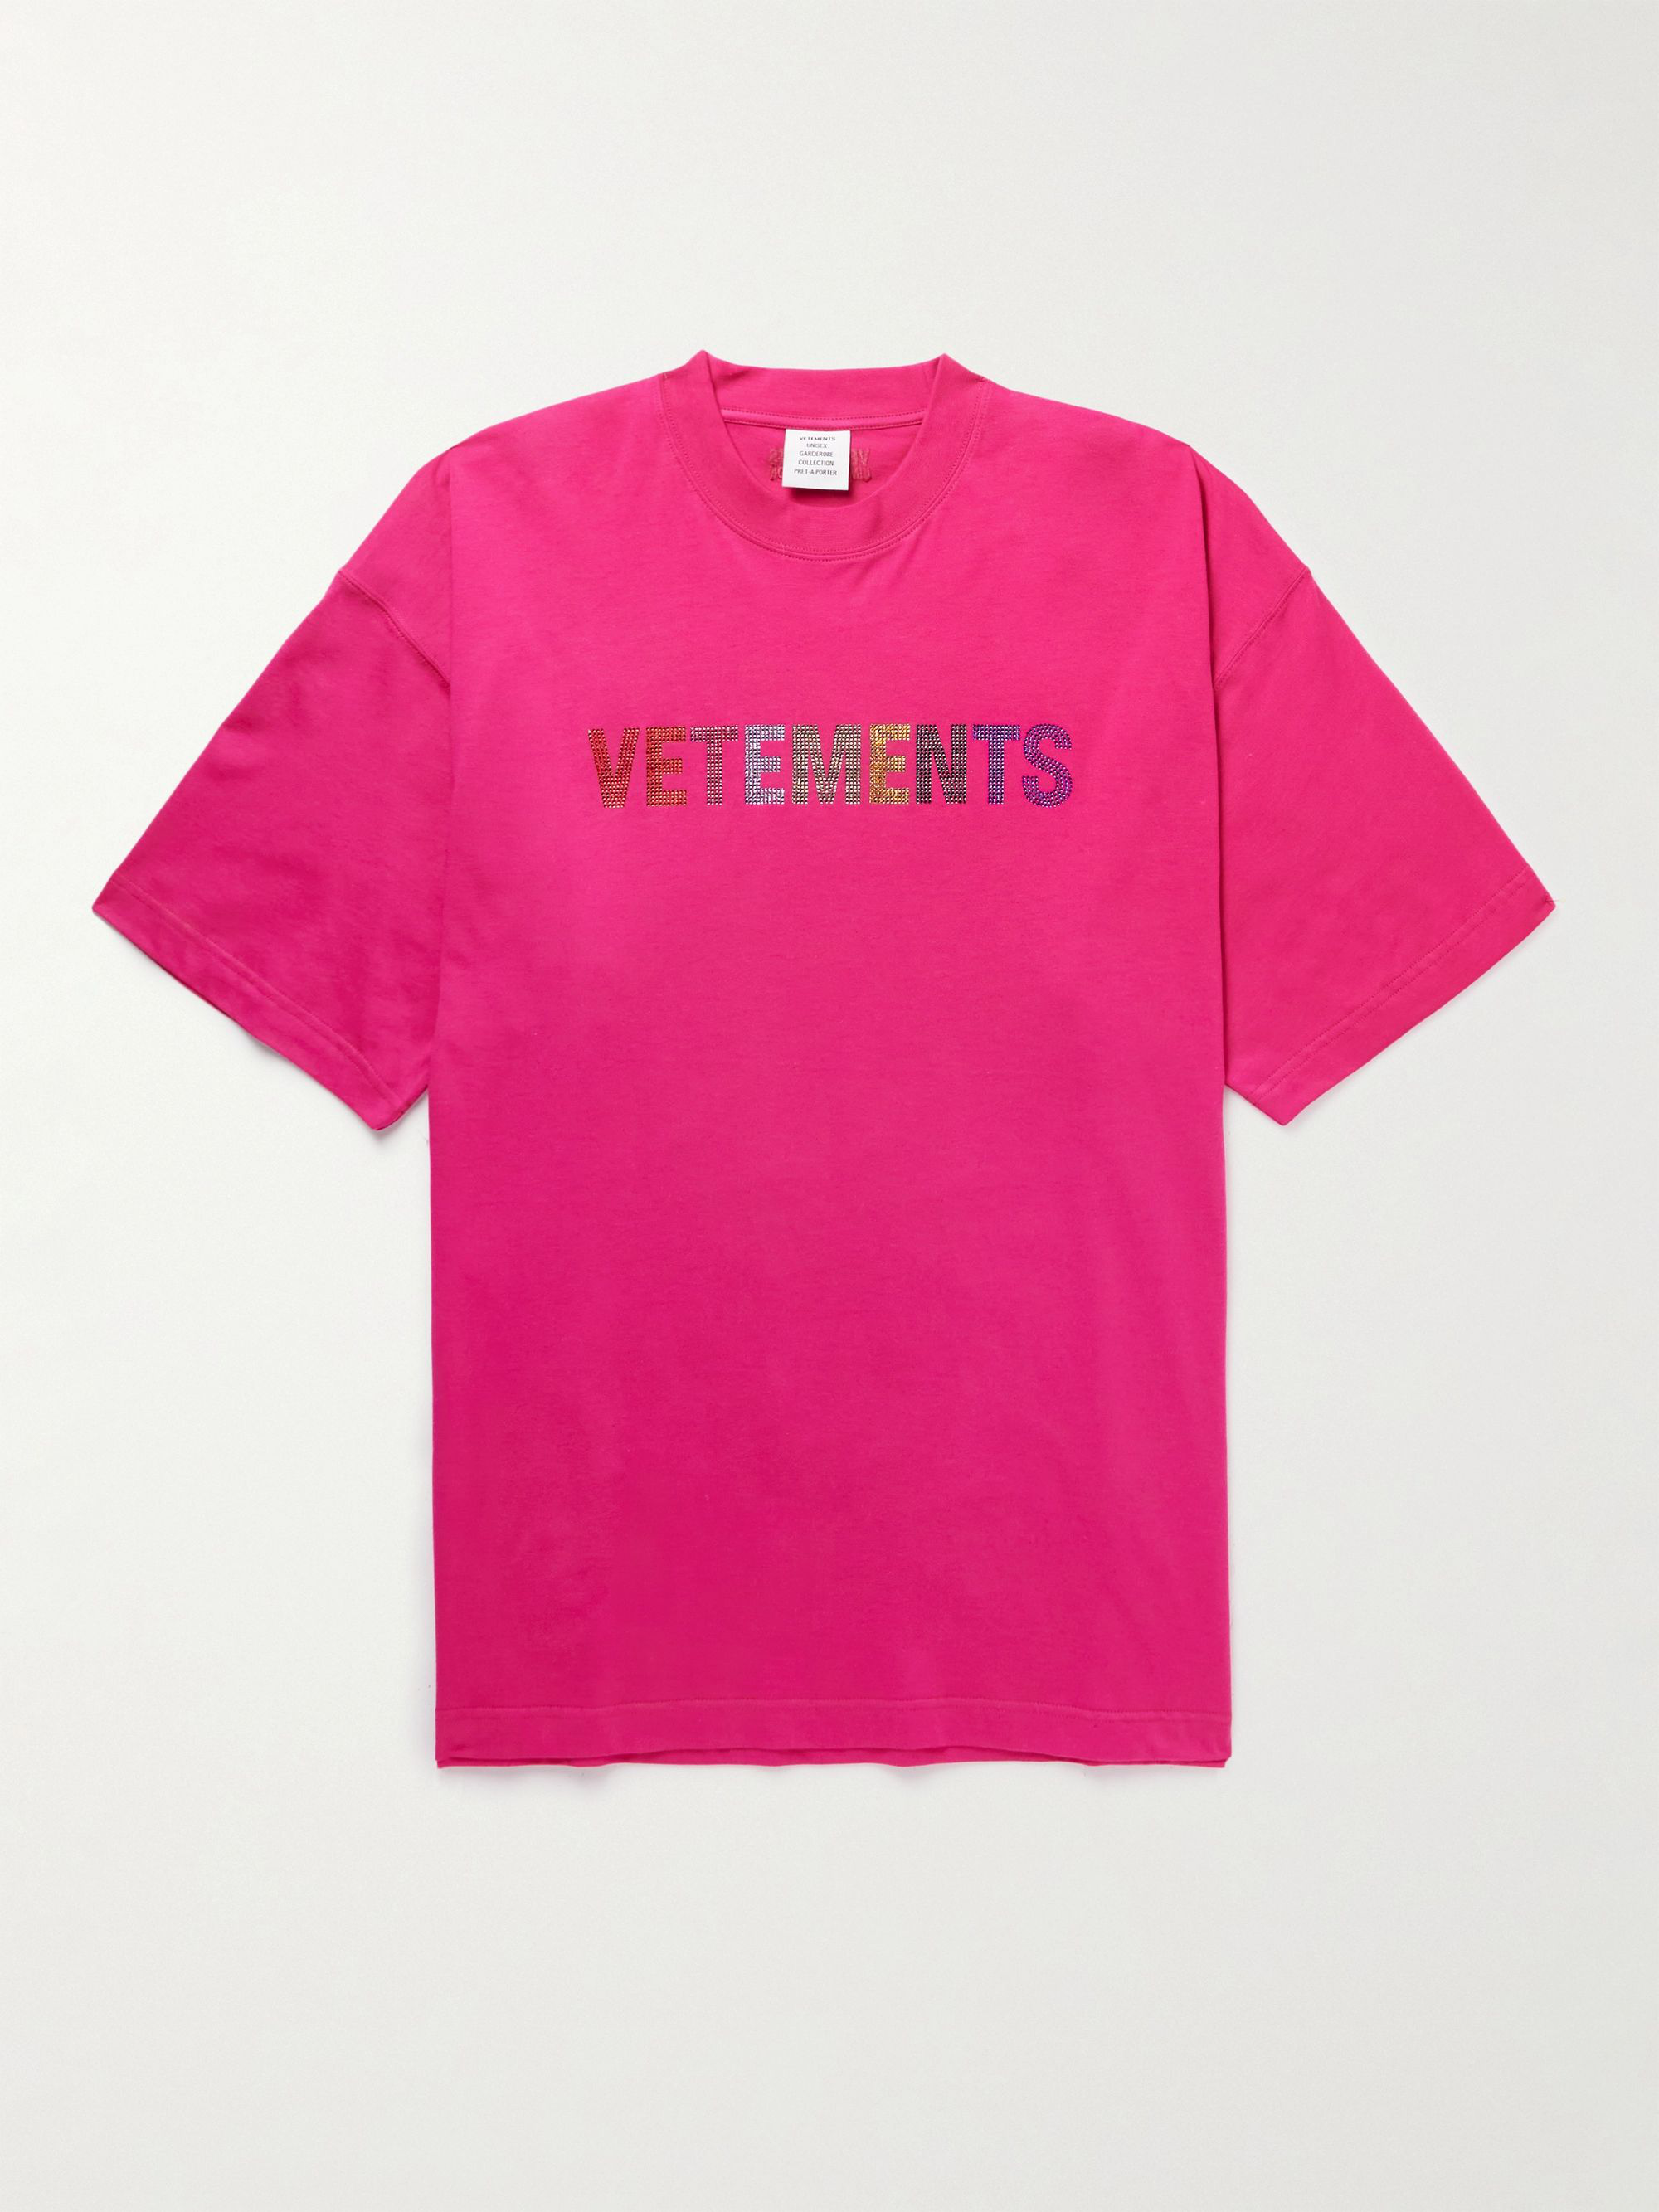

In [42]:

Image.open("./Color_data/1631.jpg")

In [43]:
getColorName(r_g_b[0], r_g_b[1], r_g_b[2])

'Razzmatazz'